In [44]:
%%system
rm /scratch/ors -r
mkdir /scratch/ors
mkdir /scratch/ors/dmg
cp ~/ors-project/data.tar.gz /scratch/ors
tar -xzvf /scratch/ors/data.tar.gz --directory /scratch/ors/
mv /scratch/ors/patches_256_v2/ /scratch/ors/clr

[]

In [1]:
from fastai.vision.all import *
from PIL import Image, ImageDraw
from random import randint

In [2]:
path = Path("/scratch/ors/")
path_clear = path/"clr"
path_damaged = path/"dmg"

In [3]:
source_image_paths = path_clear.ls()
for (i, image_path) in enumerate(source_image_paths):
    print("\r", i, end="")
    img = Image.open(image_path)
    draw = ImageDraw.Draw(img)
    r1, c1 = randint(0, 200), randint(0, 200)
    r2, c2 = randint(r1, 256), randint(c1, 256)
    draw.line((r1, c1, r2, c2), fill=0, width=5)
    img.save(path_damaged/image_path.name)
    
print()

 58

KeyboardInterrupt: 

In [4]:
def damage_image(image_path):
    img = Image.open(image_path)
    draw = ImageDraw.Draw(img)
    r1, c1 = randint(0, 200), randint(0, 200)
    r2, c2 = randint(r1, 256), randint(c1, 256)
    draw.line((r1, c1, r2, c2), fill=0, width=5)
    img.save(path_damaged/image_path.name)

In [5]:
parallel(damage_image, path_clear.ls(), n_workers=4)

(#12900) [None,None,None,None,None,None,None,None,None,None...]

In [6]:
img.shape

(256, 256)

In [7]:
dblock = DataBlock(blocks=(ImageBlock, ImageBlock),
                  get_items=get_image_files,
                  get_y=lambda x: path_clear/x.name,
                  splitter=RandomSplitter(),
                  item_tfms=Resize(224),
                  batch_tfms=[*aug_transforms(max_zoom=2.),
                             Normalize.from_stats(*imagenet_stats)])

In [25]:
dls = dblock.dataloaders(path_damaged, bs=8)

In [26]:
dls_gen = dls
dls_gen.c = 3

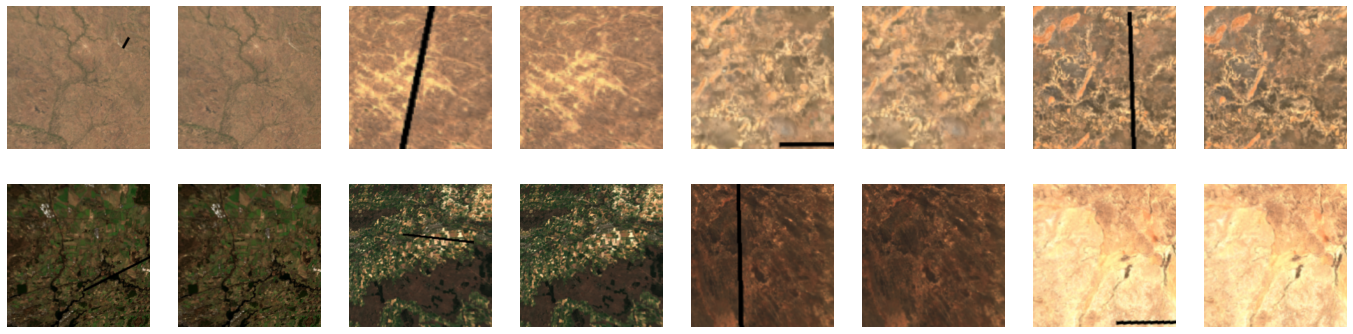

In [27]:
dls_gen.show_batch()

In [28]:
wd, y_range, loss_gen = 1e-3, (-3., 3.), MSELossFlat()

In [29]:
bbone = resnet34
# cfg = unet_config(blur=True, norm_type=NormType.Weight, self_attention=True,
#                   y_range=y_range)

In [30]:
def create_gen_learner():
    return unet_learner(dls_gen, bbone, loss_func=loss_gen)

In [31]:
learn_gen = create_gen_learner()

In [32]:
learn_gen.fit_one_cycle(2, pct_start=0.8, wd=wd)

epoch,train_loss,valid_loss,time
0,0.005254,0.005682,04:45
1,0.001129,0.001420,04:54


In [34]:
learn_gen.unfreeze()

In [37]:
learn_gen.fit_one_cycle(1, slice(1e-6,1e-3), wd=wd)

epoch,train_loss,valid_loss,time
0,0.000768,0.000775,04:48


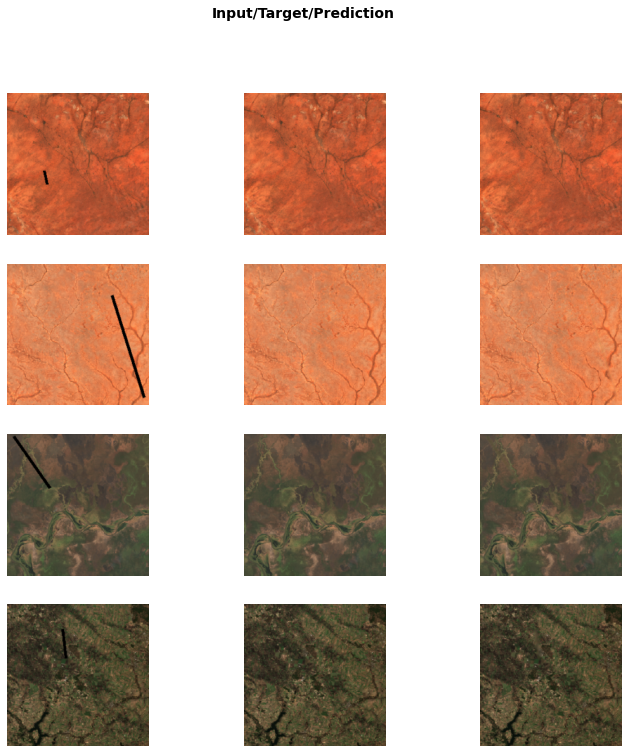

In [38]:
learn_gen.show_results(max_n=4, figsize=(12,12))

In [39]:
learn_gen.save('image_restoration')

Path('models/image_restoration.pth')